In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Theoretical Part
## 1) Hypothesis Testing – The problem of multiple comparisons [5 points]
Experimentation in AI often happens like this: <br>
A. Modify/Build an algorithm<br>
B. Compare the algorithm to a baseline by running a hypothesis test.<br>
C. If not significant, go back to step A<br>
D. If significant, start writing a paper. <br>
<br>
How many hypothesis tests, m, does it take to get to (with Type I error for each test = α):<br>
<br>
a) P(m<sup>th</sup> experiment gives significant result | m experiments lacking power to reject H<sub>0</sub>)?

b) P(at least one significant result | m experiments lacking power to reject H<sub>0</sub>)?

a) If all m experiments lack the power reject the null hypothesis, we still assume that the results come from the probability distribution of H0. The probability of a significant result is given by the probability mass to the right of the critical value, corrected as the family-wise error rate.
 
P(m<sup>th</sup> experiment gives significant result | m experiments lacking power to reject H<sub>0</sub>) = $$1 - (1-\alpha)^m$$

b) The probability of finding at least one significant result is the complement of finding no significant results.

P(at least one significant result | m experiments lacking power to reject H<sub>0</sub>) =

$$1 - (1-\alpha)^m$$

## 2) Bias and unfairness in Interleaving experiments [10 points]

Balance interleaving has been shown to be biased in a number of corner cases. An example was given during the lecture with two ranked lists of length 3 being interleaved, and a randomly clicking population of users that resulted in algorithm A winning ⅔ of the time, even though in theory the percentage of wins should be 50% for both algorithms. Can you come up with a situation of two ranked lists of length 3 and a distribution of clicks over them for which Team-draft interleaving is unfair to the better algorithm?


(inspired by: 'Large Scale Validation and Analysis of Interleaved Search Evaluation' by Chapelle et al.)

Consider an ambiguous query q.

Of all users that search for *q*, 49% intend concept *A*, 49% intend concept *B* and 2% intend concept *C*. These users would be satisfied by docs *a*, *b* or *c* respectively.


Consider two rankings: *R<sub>1</sub>(a, b, d)* and *R<sub>2</sub>(b, c, d)*, where d is not relevant.
R<sub>1</sub> satisfies 98% of all users (users intending *A* + users intending *B* = 49% + 49% = 98%), whereas R<sub>2</sub> satisfies 51% of all users (users intending *B* + users intending *C* = 49% + 2% = 51%). So R<sub>1</sub> is better than R<sub>2</sub> since R<sub>2</sub> satisfies a larger portion of users.

Because R<sub>1</sub> is better than R<sub>2</sub>, one would expect that R<sub>1</sub> wins more often than R<sub>2</sub> when using team-draft interleaving. However, R<sub>2</sub> will win in 51% of the encounters.

This is because:

* In the case of a user that is satisfied by doc *a* (49% of users), R<sub>1</sub> will always win since R<sub>2</sub> does not include doc *a*.
* In the case of a user that is satisfied by doc *b* (49% of users), two things can happen. Either R<sub>1</sub> is chosen first, or R<sub>2</sub> is chosen first. In both cases, R<sub>2</sub> contributes doc *b* to the interleaved result, and therefore R<sub>2</sub> wins.
* In the case of a user that is satisfied by doc *c* (2% of users), R<sub>2</sub> always wins, since R<sub>1</sub> does not include doc *c*.

Therefore, R<sub>1</sub> contributes a relevant click in 49% of the cases (users searching for doc *a*) while R<sub>2</sub> contributes a relevant click in 51% of the cases (users searching for doc *b* and users searching for doc *c*).

Concluding: even though R<sub>1</sub> satisfies 98% of all users and R<sub>2</sub> only 51% of users, R<sub>2</sub> will win 51% of the time when using team-draft interleaving.

# Practical part
## Step 1: Simulate Rankings of Relevance for E and P (5 points)
The function ```generate_ranking_pairs``` defined below is used to generate all possible ranking pairs of a predefined length for a given set of relevance labels, which will be used later to compare offline and online evaluation methods.

In [2]:
from itertools import product
 
def generate_ranking_pairs(grades, rank_len):
    """ Generates all possible ranking pairs, excluding pairs of 
        equal rankings

    Args:
        grades (list): Possible relevance labels in ranking.
        rank_len (int): Length of ranking pairs.

    Returns:
        generator: All possible ranking pairs.
        
    """
    
    # generate all possible rankings
    rankings = product(grades, repeat=rank_len)
    # generate all possible pairs of rankings
    pairs = product(rankings, repeat=2)    
    # exclude pairs of equal rankings
    pairs = filter(lambda pair: pair[0] != pair[1], pairs)
    
    return pairs

relevance_labels = ['HR', 'R', 'N']
rank_len = 5

ranking_pairs = list(generate_ranking_pairs(relevance_labels, rank_len))
print('Total number of possible ranking pairs: ', len(ranking_pairs))

Total number of possible ranking pairs:  58806


## Step 2: Implement Evaluation Measures (10 points)
In this section, several offline evaluation measures are implemented. The first one, average precision, is a simple binary evaluation method, which is calculated as the average of precisions at relevant documents.

In [3]:
def average_precision(rankings):    
    """Calculates Average Precision (AP) = Average of precisions at relevant documents

    Args:
        rankings (list): ranked result of query.

    Returns:
        float: The average precision of rankings.
        
    """
    relevant = 0
    numerator = 0
    for rank, rel in enumerate(rankings):
        rank += 1
        if rel == 'R' or rel == 'HR':
            relevant += 1
            numerator += relevant/rank
    return numerator/len(rankings)

We now move to some multi-graded evaluation measures:

The scores for relevance labels that are used are 0, 1 and 5 for N, R and HR respectively (equal to example in slides).

The nDCG@k measures requires the total number of relevant and highly relevant documents in the entire collection. Since
for this dummy example there does not really exist a corpus, another approach is required:

The ```nDCGk``` function is fed a ranking of length 5 (one of the permutations created in Step 1). This list of five is treated
as the corpus. The list consisting of the first k elements is seen as the result of a query q, and the DCGk of this
list is calculated by the ```DCGk``` function. To find the perfect ranking (for normalization), the corpus list is sorted (descending)
and the DCGk of the top k elements of the resulting list is calculated. The result is then used for normalization 
in ```nDCGk```.

In [4]:
import math

def DCGk(rankings):
    """Calculates Discounted Cumulative Gain (DCG)

    Args:
        rankings (list): ranked result of query.

    Returns:
        float: The discounted cumulative gain.
        
    """
    discounted_gain = 0
    for rank, rel in enumerate(rankings):
        rank += 1
        gain = (2**rel)-1
        discount = 1/math.log(rank+1,2)    
        discounted_gain += gain*discount        
    return discounted_gain

def nDCGk(rankings, k=3):
    """Calculates Normalized Discounted Cumulative Gain at rank k (nDCG@k)

    Args:
        rankings (list): ranked result of query. (treated as corpus)
        k (int): rank k. Value of 3 is used if no argument is given.

    Returns:
        float: The normalized discounted gain at rank k.
        
    """
    # translate relevance to corresponding score for calculations
    rankings = [5 if x is 'HR' else 1 if x is 'R' else 0 for x in rankings]
    # calculate discounted gain for top k
    DCG = DCGk(rankings[:k])
    # sort all relevant documents (descending) in the corpus by their 
    # relative relevance to find best possible DCG result (perfect ranking)
    perfect_DCG = DCGk(sorted(rankings, reverse=True)[:k])
    # normalize discounted_gain by this result
    if perfect_DCG == 0:
        return 0
    return DCG/perfect_DCG

#nDCGk(ranking_pairs[0][0])

The expected reciprocal rank (ERR) metric supports graded relevance judgments and assumes a cascade browsing model.

In [5]:
def ERR(rankings, k=5):
    """Computes the Expected Reciprocal Rank (ERR) metric in linear time. Based on paper by Chapelle et al.

    Args:
        rankings (list): ranked result of query.
        k (int): rank k. Value of 5 is used if no argument is given.

    Returns:
        float: the Expected Reciprocal Rank (ERR).
        
    """
    # translate relevance to corresponding score for calculations
    rankings = [5 if x is 'HR' else 1 if x is 'R' else 0 for x in rankings]
    p = 1.0
    err = 0.0
    for rank, rel in enumerate(rankings[:k]):
        rank += 1
        R = ((2**rel)-1) / (2**max(rankings))
        err += p*(R/rank)
        p *= 1-R
    return err

# ERR(ranking_pairs[100][1])

## Step 3: Calculate the delta measure (0 points)
Using the offline evaluation measures we implemented above, we can quantify the difference between ranking pairs as the "delta measure". We'll apply this measure to the ranking pairs generated in step 1.

In [6]:
def delta_measure(P, E, measure):
    """Computes the delta of P and E for average precision, nDCG@k or ERR.

    Args:
        P (list): ranked result of production algorithm.
        E (list): ranked result of experimental algorithm.
        measure (string): measure to be calculated (average precision, nDCGk, ERR)

    Returns:
        float: delta of E and P. If < 0, E does not outperform P.
        
    """
    if measure == 'average precision':
        P_measure = average_precision(P)
        E_measure = average_precision(E)
    elif measure == 'nDCGk':
        P_measure = nDCGk(P)
        E_measure = nDCGk(E)
    elif measure == 'ERR':
        P_measure = ERR(P)
        E_measure = ERR(E)
    
    return E_measure - P_measure

In [7]:
relevance_labels = ['HR', 'R', 'N']
rank_len = 5

ranking_pairs = list(generate_ranking_pairs(relevance_labels, rank_len))

delta_ranking_ap = [delta_measure(pair[0], pair[1], 'average precision') for pair in ranking_pairs 
                    if delta_measure(pair[0], pair[1], 'average precision') > 0]
delta_ranking_ndcgk = [delta_measure(pair[0], pair[1], 'nDCGk') for pair in ranking_pairs 
                    if delta_measure(pair[0], pair[1], 'nDCGk') > 0]
delta_ranking_err = [delta_measure(pair[0], pair[1], 'ERR') for pair in ranking_pairs 
                    if delta_measure(pair[0], pair[1], 'ERR') > 0]

print('Using AP, E outperforms P in {} out of {} times.'.format(len(delta_ranking_ap), len(ranking_pairs)))
print('Using nDCGk, E outperforms P in {} out of {} times.'.format(len(delta_ranking_ndcgk), len(ranking_pairs)))
print('Using ERR, E outperforms P in {} out of {} times.'.format(len(delta_ranking_err), len(ranking_pairs)))

Using AP, E outperforms P in 27954 out of 58806 times.
Using nDCGk, E outperforms P in 28793 out of 58806 times.
Using ERR, E outperforms P in 29403 out of 58806 times.


## Step 4: Implement Interleaving (15 points)
The function ```interleave``` implements the Team Draft Interleaving algorithm, which can be applied to a pair of lists containing ranked relevance labels. It is assumed that the two lists contain different documents/urls.

In [8]:
from random import randint

def interleave(ranking_A, ranking_B):
    """
    Interleaves rankings from two different ranking algorithms into 
    one ranking based on Team Draft Interleaving. Both rankings are
    assumed to have equal length.
    
    Args:
        ranking_A (list): Ranking of algorithm A.
        ranking_B (list): Ranking of algorithm B.
        
    Returns:
        dict: Dict containing two lists: the interleaved ranking and the origins.
        
    """
    ranking_I = []
    origins = []
    i = 0
    while len(ranking_I) < len(ranking_A):
        # A wins
        if randint(0,1) == 0:
            origins += [0,1]
            ranking_I.append(ranking_A[i])
            ranking_I.append(ranking_B[i])
        # B wins
        else:
            origins += [1,0]
            ranking_I.append(ranking_B[i])
            ranking_I.append(ranking_A[i])
        i += 1
    if len(ranking_I) > len(ranking_A):
        ranking_I = ranking_I[0:-1]
        origins = origins[0:-1]
    return {'ranking': ranking_I, 'origins': origins}

In [9]:
ranking_A = ['N','N','R','HR','N']
ranking_B = ['R','HR','N','N','R']
interleaved_ranking = interleave(ranking_A, ranking_B)
print('Ranking A:\t\t', ranking_A)
print('Ranking B:\t\t', ranking_B)
print('Interleaved ranking:\t', interleaved_ranking['ranking'])

Ranking A:		 ['N', 'N', 'R', 'HR', 'N']
Ranking B:		 ['R', 'HR', 'N', 'N', 'R']
Interleaved ranking:	 ['R', 'N', 'HR', 'N', 'N']


## Step 5: Implement User Clicks Simulation (15 points)
Having interleaved all the ranking pairs an online experiment could be ran. However, given that we do not have any users (and the entire homework is a big simulation) we will simulate user clicks. Two click models, the random click model and simple dependent click model, are implemented below.
### Random Click Model

In [10]:
from random import uniform

class RandomClickModel:
    '''
    Implements a Random Click Model. This model decides to click on a document
    with a probability P_click without taking anything else into account. P_click
    is learned from a click log. The default click log is from Yandex.
    '''
    
    def __init__(self, click_log_path = 'YandexRelPredChallenge.txt'):
        self.P_click = self.train(click_log_path)
        
    def train(self, click_log_path):
        '''
        Estimates the only parameter P_click of the Random Click Model using a click log
        by dividing the total amount of clicks by the total amount of shown documents.

        Args:
            click_log_path (str): Location of the click log.

        Return:
            float: The P_click parameter used to decide whether to click on a document.

        '''
        shown_docs = 0
        clicks = 0
        with open(click_log_path,'r') as f:
            for line in f:
                line = line.split()

                # Count all shown docs
                if line[2] == 'Q':
                    shown_docs += len(line)-5

                # Count all clicks
                else:
                    clicks += 1
        P_click = clicks/float(shown_docs)
        return P_click

    def predictProb(self, ranking):
        '''
        Generates the probability for each document in a ranking to be clicked on
        based on a Random Click Model.

        Args:
            ranking (list): List of ranked documents represented by relevance.

        Return:
            list: A list of click probabilities for each document in the ranking.
        '''
        click_probabilities = []
        for doc in ranking:
            click_probabilities.append(self.P_click)
        return click_probabilities

    def assignClicks(self, ranking):
        '''
        Based on their click probabilities, either do or do not assign a click to each document.

        Args:
            ranking_probabilities (List): A list of click probability and document tuples.
            P_click (float): Probability used to decide whether to click on a document.

        Return:
            list: A list representing clicks with 1's on documents in ranking with the same index.
        '''
        click_probabilities = self.predictProb(ranking)
        clicks = []
        for prob in click_probabilities:
            if uniform(0,1) < prob:
                clicks.append(1)
            else:
                clicks.append(0)
        return clicks

In [11]:
ranking_I = ['HR','R','HR','N','R']
clicks = RandomClickModel().assignClicks(ranking_I)
print(clicks)

[0, 0, 0, 0, 0]


### Simple Dependent Click Model

In [12]:
from random import random
from collections import Counter


class SdcmClickModel(object):
    """ Implements a Simple Dependent Click Model (SDCM). Generates clicks starting
        from the first rank, and stochastically decides if a clicked result is 
        satisfactory, using probabilities trained on a click log. If the result was 
        not satisfactory, the next result is examined, and then clicked with a 
        probability dependent on the corresponding relevance label. The probabilities
        for each of the relevance labels are taken from the book "Click Models for 
        Web Search".
    
    Args:
        click_log_path (str): Location of the click log.
        attr_model (str): Model used for attractiveness parameters
                            (perfect/navigational/informative)
    """

    """Click model attractiveness parameters"""
    attr_perf = {'HR':1.0, 'R':0.5, 'N':0.0}
    attr_nav = {'HR':0.95, 'R':0.5, 'N':0.05}
    attr_inf = {'HR':0.9, 'R':0.7, 'N':0.4} 
    
    def __init__(self, click_log_path='YandexRelPredChallenge.txt', attr_model='nav'):
        self.click_log_path = click_log_path
        if attr_model == 'nav':
            self.attr_model = SdcmClickModel.attr_nav
        elif attr_model == 'perf':
            self.attr_model = SdcmClickModel.attr_perf            
        elif attr_model == 'inf':
            self.attr_model = SdcmClickModel.attr_inf
        else:
            raise ValueError('The attractiveness model "{}" is not available.' \
                            ' Choose from "nav", "perf" or "inf".'.format(attr_model))
        self.params = self.learnParams()
            
    def learnParams(self):
        """ Learns parameters for simple dependent click model.

        Returns:
            dict: Learnt click model parameters.

        """

        with open(self.click_log_path,'r') as f:
            # global rank click counter
            rank_counter = Counter()
            # counter for clicks on consecutive ranks
            pair_counter = Counter()
            for line in f:
                line = line.split()
                time_passed = line[1]
                if time_passed == '0':
                    prev_clicked_rank = None
                if line[2] == 'Q':
                    results = line[5:]
                else:
                    url = line[3]
                    try:
                        clicked_rank = results.index(url)
                    except: 
                        pass
                    rank_counter[clicked_rank] += 1
                    if prev_clicked_rank is not None:
                        pair_counter[prev_clicked_rank] += 1
                    prev_clicked_rank = clicked_rank
        lambdas = {r+1:pair_counter[r]/rank_counter[r] for r in pair_counter.keys()}
        return lambdas

    
    def attrProbs(self, ranking):
        """ Assigns attractiveness probabilities for list of relevance labels.

        Args:
            ranking (list): Ranked list of relevance labels.

        Returns:
            list: List of attractiveness probabilities corresponding with ranking.

        """
        probs = [self.attr_model[label] for i, label in enumerate(ranking)]
        return probs

    def assignClicks(self, ranking):
        """ Assigns clicks based on attractiveness and satisfactoriness probabilities.

        Args:
            ranking (list): Ranked list of relevance labels.

        Returns:
            list: Assigned clicks.

        """
        probs = self.attrProbs(ranking)
        
        clicks = []  
        for i in range(len(probs)):
            if i == 0:
                
                # For first result, click probability equals attractiveness
                p_click = probs[i]
            else:
                prev_click = clicks[i-1]
                if prev_click == 1:
                    p_satisf = 1 - self.params[i]
                    
                    # Stochastically decide satisfactoriness    
                    outcome = random()
                    if outcome < p_satisf:
                        
                        # When the clicked result was satisfactory, stop
                        clicks += ([0] * (len(probs) - len(clicks)))
                        break
                    else:
                        p_click = probs[i]
                else:
                    p_click = probs[i]

            # Stochastically decide click 
            outcome = random()
            if outcome < p_click:
                clicks.append(1)
            else: clicks.append(0)
        return clicks

In [13]:
ranking = ['HR', 'R', 'R', 'N', 'HR', 'N', 'R']
sdcm_clicks = SdcmClickModel().assignClicks(ranking)
rcm_clicks = RandomClickModel().assignClicks(ranking)

print('Ranking: \t\t\t\t\t\t\t', ranking)
print('Clicks generated by Random Click Model: \t\t\t', rcm_clicks)
print('Clicks generated by Simple Dependent Click Model: \t\t', sdcm_clicks)

Ranking: 							 ['HR', 'R', 'R', 'N', 'HR', 'N', 'R']
Clicks generated by Random Click Model: 			 [1, 1, 0, 0, 0, 0, 0]
Clicks generated by Simple Dependent Click Model: 		 [1, 0, 0, 0, 0, 0, 0]


## Step 6: Simulate Interleaving Experiment (10 points)
Having implemented the click models, it is time to run the simulated experiment.
For each of interleaved ranking run N simulations for each one of the click models implemented and measure the proportion p of wins for E.
(Note 7: Some of the models above include an attractiveness parameter 𝑎uq. Use the relevance label to assign this parameter by setting 𝑎uq for a document u in the ranked list accordingly. (See Click Models for Web Search)

In [15]:
def simulate_experiment(ranked_pairs, N, click_model):
    '''
    Simulate an on-line user experiment to compare the ranking performance
    of two algorithms, P and E.
    
    Args:
        interleaved_rankings (List): A list containing interleaved rankings and their origins
        N (int): The number of simulations to run per click model.
        click_model (object): An object representing a click model able to assign clicks to a ranking.
        
    Returns:
        dict: dictionary with win ratios for E and P
    '''
    
    # Obtain interleaved rankings
    interleaved_rankings = []
    for ranking_A, ranking_B in ranked_pairs:
        interleaved_rankings.append(interleave(ranking_A, ranking_B))
    
    # Simulate N experiments
    win_ratios_E = []
    total_wins_E = 0 
    win_ratios_P = []
    total_wins_P = 0
    total_draws = 0
    
    for interleaved_ranking in interleaved_rankings:
        # Obtain ranking and the originating algorithm
        ranking = interleaved_ranking['ranking']
        origins = interleaved_ranking['origins']
        
        wins_E = 0
        wins_P = 0
        
        for i in range(N):
            # Simulate clicks
            clicks = click_model.assignClicks(ranking)

            # Initialize clicks
            clicks_E = 0
            total_clicks = 0
            
            for click, origin in zip(clicks, origins):
                total_clicks += click
                if click + origin == 2:
                    clicks_E += 1
            clicks_P = total_clicks - clicks_E
            if clicks_E > clicks_P:
                wins_E += 1
                total_wins_E += 1
            elif clicks_E < clicks_P:
                wins_P += 1
                total_wins_P += 1
            else:
                total_draws += 1
                
        win_ratio_E = wins_E/float(N)
        win_ratio_P = wins_P/float(N)
        win_ratios_E.append(win_ratio_E)
        win_ratios_P.append(win_ratio_P)
        
    total_win_ratio_E = total_wins_E / float(len(ranked_pairs) * N)
    total_win_ratio_P = total_wins_P / float(len(ranked_pairs) * N)       
    total_draw_ratio = 1 - total_win_ratio_E - total_win_ratio_P 
    
    results = {'wrE':win_ratios_E, 'wrP':win_ratios_P,
              'twE':total_win_ratio_E, 'twP':total_win_ratio_P, 'tdr':total_draw_ratio}
        
    return results

In [16]:
# Obtain ranked pairs from algorithm P and E
grades = ['HR', 'R', 'N']
rank_len = 5
ranked_pairs = list(generate_ranking_pairs(grades, rank_len))

# Specify simulation parameters
N = 10
click_log_path = 'YandexRelPredChallenge.txt'
sdcm_click_model = SdcmClickModel(click_log_path)
rcm_click_model = RandomClickModel(click_log_path)

# Compute win ratio of algorithm E (1) over P (0)
sdcm_results = simulate_experiment(ranked_pairs, N, sdcm_click_model)
rcm_results = simulate_experiment(ranked_pairs, N, rcm_click_model)

print('Proportion of wins for E using RCM: ', rcm_results['twE'])
print('Proportion of wins for E using SDCM: ', sdcm_results['twE'])

Proportion of wins for E using RCM:  0.22188552188552188
Proportion of wins for E using SDCM:  0.3621365166819712


## Step 7: Results and Analysis (30 points)
We now have five ways to evaluate the performance of algorithm E compared to algorithm P. The first three are  offline metrics (AP, nDCG and ERR), for which we can calculate the difference (delta) between the performance of P and E for each ranking pair. The other two methods are part of online evaluation: use team draft interleaved rankings to simulate wins using either a Random Click Model or a Simple Dependant Click Model.

## Offline Evaluation
For all evaluation metrics we want to test whether the results are statistically significant. For the offline evaluations student's t-test is used. Results that are significant are very unlikely (<0.05) due to chance.

In [17]:
import numpy as np
import scipy.stats as stats

# Obtain ranking pairs from algorithm P and E
grades = ['HR', 'R', 'N']
rank_len = 5
ranking_pairs = list(generate_ranking_pairs(grades, rank_len))

##### Offline #####
# Perform offline evaluation experiments using the three different
# evaluation metrics: average precision, nDCGk and ERR
delta_AP, delta_nDCGk, delta_ERR = [], [], []
for P, E in ranked_pairs:
    delta_AP.append(delta_measure(P,E,'average precision'))
    delta_nDCGk.append(delta_measure(P,E,'nDCGk'))
    delta_ERR.append(delta_measure(P,E,'ERR'))

# Compute win ratio's per offline evaluation metric
delta_AP_w = np.array([x for x in delta_AP if x > 0])
delta_nDCGk_w = np.array([x for x in delta_nDCGk if x > 0])
delta_ERR_w = np.array([x for x in delta_ERR if x > 0])
n = len(ranking_pairs)
win_ratio_AP = len(delta_AP_w)/len(delta_AP)
win_ratio_nDCGk = len(delta_nDCGk_w)/len(delta_nDCGk)
win_ratio_ERR = len(delta_ERR_w)/len(delta_ERR)

# Perform statistical tests on offline evaluations
# The Null Hypothesis is that P and E perform the same:
# their test statistic values are identically distributed.
# Three different test statistics will be used (AP, nDCGk and ERR).
t_AP = np.mean(delta_AP_w)/(np.std(delta_AP_w)/len(delta_AP_w))
p_AP = 1 - stats.norm(0,1).cdf(t_AP)
print('----- Offline Evaluation -----')
print('Average Precision:')
print('- t-value: {} (Computed from all delta values)'.format(t_AP))
print('- p-value: {} (Computed over deltas)'.format(p_AP))
print('- Win ratio: {} (Ratio E has a higher AP than P)\n'.format(win_ratio_AP))

t_nDCGk = np.mean(delta_nDCGk_w)/(np.std(delta_nDCGk_w)/len(delta_nDCGk_w))
p_nDCGk = 1 - stats.norm(0,1).cdf(t_nDCGk)
print('nDCGk:')
print('- t-value: {} (Computed from all delta values)'.format(t_nDCGk))
print('- p-value: {} (Computed over deltas)'.format(p_nDCGk))
print('- Win ratio: {} (Ratio E has a higher nDCGk than P)\n'.format(win_ratio_nDCGk))

t_ERR = np.mean(delta_ERR_w)/(np.std(delta_ERR_w)/len(delta_ERR_w))
p_ERR = 1 - stats.norm(0,1).cdf(t_ERR)
print('ERR:')
print('- t-value: {} (Computed from all delta values)'.format(t_ERR))
print('- p-value: {} (Computed over deltas)'.format(p_ERR))
print('- Win ratio: {} (Ratio E has a higher ERR than P)'.format(win_ratio_ERR))

----- Offline Evaluation -----
Average Precision:
- t-value: 41711.90886930119 (Computed from all delta values)
- p-value: 0.0 (Computed over deltas)
- Win ratio: 0.475359657177839 (Ratio E has a higher AP than P)

nDCGk:
- t-value: 40521.95735767162 (Computed from all delta values)
- p-value: 0.0 (Computed over deltas)
- Win ratio: 0.48962690881882803 (Ratio E has a higher nDCGk than P)

ERR:
- t-value: 36969.81074626947 (Computed from all delta values)
- p-value: 0.0 (Computed over deltas)
- Win ratio: 0.5 (Ratio E has a higher ERR than P)


## Online Evaluation
Using each offline evaluation metric, we create a subset of the data for which algorithm E always wins (delta > 0), effectively simulating a dataset where algorithm E is better than P. We now use this dataset to perform online evaluation on, which allows us to compare offline and online methods to see whether they agree. Since we have chosen datasets for which according to the offline metrics E is always better, one might expect that online evaluation will have similar results. However, this is not true for the Random Click Model, since it does not care about anything except for the overall click rate. Thus evaluation metric will contradict the offline evaluation metrics and assign equal wins to P and E. The Simple Dependent Click Model takes attractiveness into account, which we have assumed to be correlated to relevance. Thus, the SDCM will assign more clicks to documents originating from ranking E, resulting in a higher proportion of win for E. This is more in line with the offline evaluation metrics, although it is still a probabilistic click model and will, unlike the offline metrics, not assign all wins to E.

In [18]:
# Run online experiments using team draft interleaving and 
# three different click models.
N = 10
rcm_click_model = RandomClickModel(click_log_path)
sdcm_click_model = SdcmClickModel(click_log_path)

# Compute win ratio of algorithm E (1) over P (0)
win_ratios_RCM = simulate_experiment(ranking_pairs, N, SdcmClickModel())
win_ratios_SDCM = simulate_experiment(ranking_pairs, N, RandomClickModel())

# Select ranking pairs for which E wins
AP_w = [rp for rp in ranking_pairs if delta_measure(rp[0],rp[1],'average precision') > 0]
nDCGk_w = [rp for rp in ranking_pairs if delta_measure(rp[0],rp[1],'nDCGk') > 0]
ERR_w = [rp for rp in ranking_pairs if delta_measure(rp[0],rp[1],'ERR') > 0]

# Calculate results for data set selected using AP measure
AP_sdcm_results = simulate_experiment(AP_w, N, sdcm_click_model)
AP_rcm_results = simulate_experiment(AP_w, N, rcm_click_model)

AP_rcm_draw_ratio = AP_rcm_results['tdr']
AP_rcm_win_ratio_E = AP_rcm_results['twE']
AP_rcm_win_ratio_P = AP_rcm_results['twP']

AP_sdcm_draw_ratio = AP_sdcm_results['tdr']
AP_sdcm_win_ratio_E = AP_sdcm_results['twE']
AP_sdcm_win_ratio_P = AP_sdcm_results['twP']

# Calculate results for data set selected using nDCGK measure
nDCGk_sdcm_results = simulate_experiment(nDCGk_w, N, sdcm_click_model)
nDCGk_rcm_results = simulate_experiment(nDCGk_w, N, rcm_click_model)

nDCGk_rcm_draw_ratio = nDCGk_rcm_results['tdr']
nDCGk_rcm_win_ratio_E = nDCGk_rcm_results['twE']
nDCGk_rcm_win_ratio_P = nDCGk_rcm_results['twP']

nDCGk_sdcm_draw_ratio = nDCGk_sdcm_results['tdr']
nDCGk_sdcm_win_ratio_E = nDCGk_sdcm_results['twE']
nDCGk_sdcm_win_ratio_P = nDCGk_sdcm_results['twP']

# Calculate results for data set selected using AP measure
ERR_sdcm_results = simulate_experiment(ERR_w, N, sdcm_click_model)
ERR_rcm_results = simulate_experiment(ERR_w, N, rcm_click_model)

ERR_rcm_draw_ratio = ERR_rcm_results['tdr']
ERR_rcm_win_ratio_E = ERR_rcm_results['twE']
ERR_rcm_win_ratio_P = ERR_rcm_results['twP']

ERR_sdcm_draw_ratio = ERR_sdcm_results['tdr']
ERR_sdcm_win_ratio_E = ERR_sdcm_results['twE']
ERR_sdcm_win_ratio_P = ERR_sdcm_results['twP']

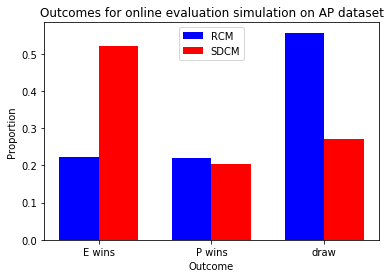

Proportion of wins for E using SDCM: 0.522


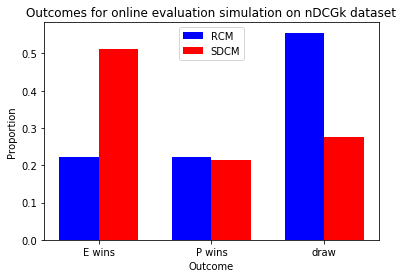

Proportion of wins for E using SDCM: 0.511


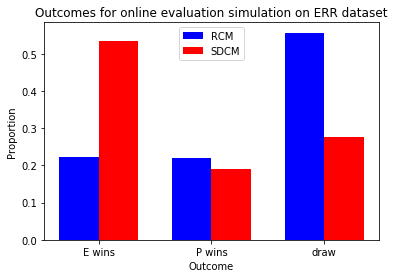

Proportion of wins for E using SDCM: 0.535


In [19]:
fig, ax = plt.subplots()

index = np.arange(3)
bar_width = 0.35


rects1 = plt.bar(index, [AP_rcm_win_ratio_E, 
                         AP_rcm_win_ratio_P,
                         AP_rcm_draw_ratio], 
                 bar_width,
                 color='b',
                 label='RCM', 
                 align='center')

rects2 = plt.bar(index + bar_width, [AP_sdcm_win_ratio_E, 
                         AP_sdcm_win_ratio_P, 
                         AP_sdcm_draw_ratio], 
                 bar_width,
                 color='r',
                 label='SDCM', 
                 align='center')

plt.xlabel('Outcome')
plt.ylabel('Proportion')
plt.title('Outcomes for online evaluation simulation on AP dataset')

plt.xticks(index + bar_width/2, ('E wins', 'P wins', 'draw'))
plt.legend()


plt.show()

print('Proportion of wins for E using SDCM: {:.3f}'.format(AP_sdcm_win_ratio_E))

rects1 = plt.bar(index, [nDCGk_rcm_win_ratio_E, 
                         nDCGk_rcm_win_ratio_P,
                         nDCGk_rcm_draw_ratio], 
                 bar_width,
                 color='b',
                 label='RCM', 
                 align='center')

rects2 = plt.bar(index + bar_width, [nDCGk_sdcm_win_ratio_E, 
                         nDCGk_sdcm_win_ratio_P, 
                         nDCGk_sdcm_draw_ratio], 
                 bar_width,
                 color='r',
                 label='SDCM', 
                 align='center')

plt.xlabel('Outcome')
plt.ylabel('Proportion')
plt.title('Outcomes for online evaluation simulation on nDCGk dataset')
plt.xticks(index + bar_width/2, ('E wins', 'P wins', 'draw'))
plt.legend()


plt.show()

print('Proportion of wins for E using SDCM: {:.3f}'.format(nDCGk_sdcm_win_ratio_E))

rects1 = plt.bar(index, [ERR_rcm_win_ratio_E, 
                         ERR_rcm_win_ratio_P,
                         ERR_rcm_draw_ratio], 
                 bar_width,
                 color='b',
                 label='RCM', 
                 align='center')

rects2 = plt.bar(index + bar_width, [ERR_sdcm_win_ratio_E, 
                         ERR_sdcm_win_ratio_P, 
                         ERR_sdcm_draw_ratio], 
                 bar_width,
                 color='r',
                 label='SDCM', 
                 align='center')

plt.xlabel('Outcome')
plt.ylabel('Proportion')
plt.title('Outcomes for online evaluation simulation on ERR dataset')
plt.xticks(index + bar_width/2, ('E wins', 'P wins', 'draw'))
plt.legend()


plt.show()

print('Proportion of wins for E using SDCM: {:.3f}'.format(ERR_sdcm_win_ratio_E))

Using a  1-sample 1-sided proportion test, we show that E significantly outperforms P as expected.

Concluding, the offline and online measures agree in the sense that E significantly outperforms P in both offline and online measures (SDCM). 